# Imports

In [80]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Dense, Flatten, Dropout, MaxPool2D
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
%matplotlib inline

# Importing the dataset

In [81]:
data = pd.read_csv("/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv")
data.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [82]:
trainPath = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train"

# Sample Images of each class

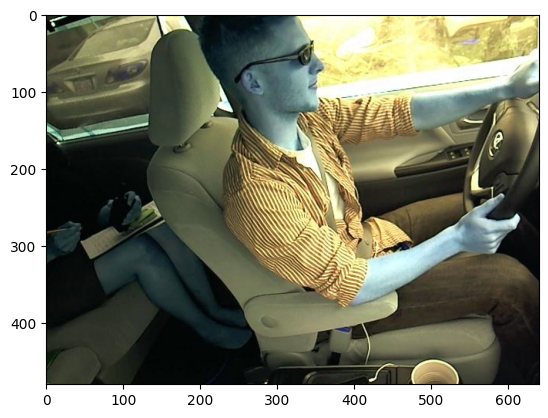

In [83]:
# Safe driving
img = cv2.imread("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c0/img_100026.jpg")
img.shape
plt.imshow(img)

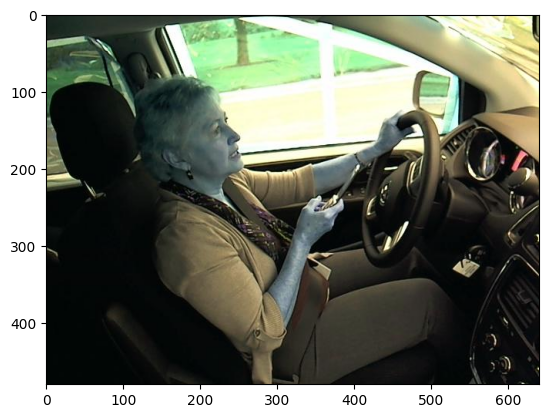

In [84]:
# Texting - Right
img = cv2.imread("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c1/img_100403.jpg")
img.shape
plt.imshow(img)

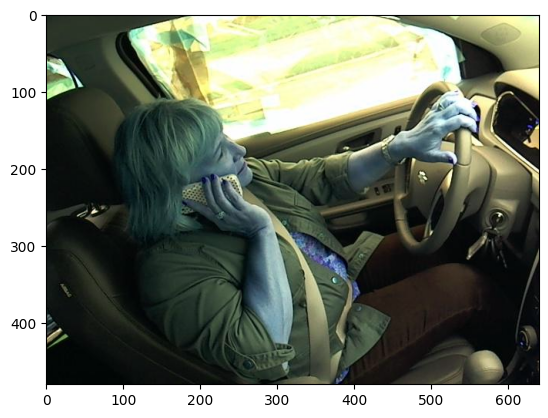

In [85]:
# Talking on the phone - Right
img = cv2.imread("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c2/img_100242.jpg")
img.shape
plt.imshow(img)

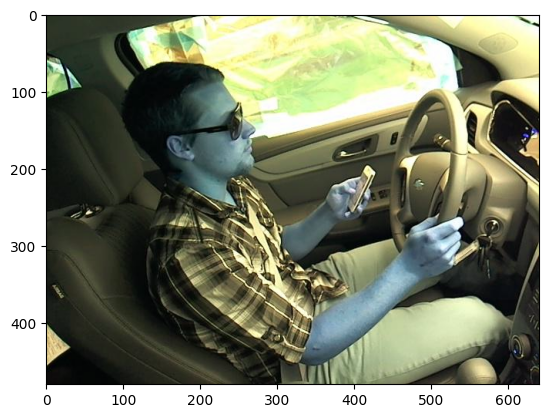

In [86]:
# Texting - Left
img = cv2.imread("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c3/img_100545.jpg")
img.shape
plt.imshow(img)

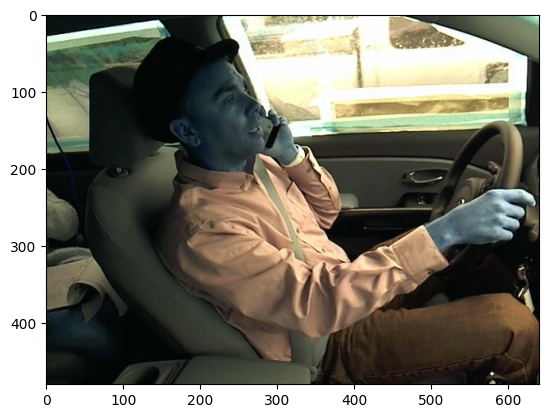

In [87]:
# Talking on the phone - Left
img = cv2.imread("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c4/img_10050.jpg")
img.shape
plt.imshow(img)

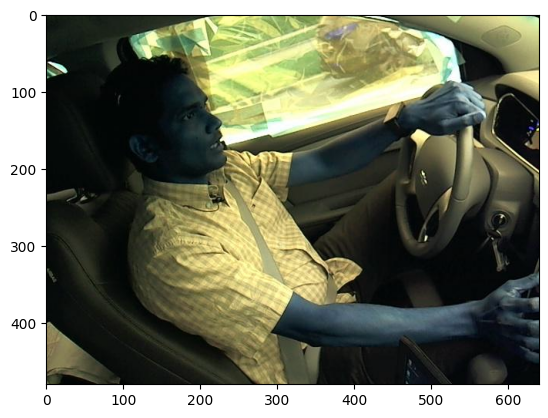

In [88]:
# Operating the radio
img = cv2.imread("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c5/img_100469.jpg")
img.shape
plt.imshow(img)

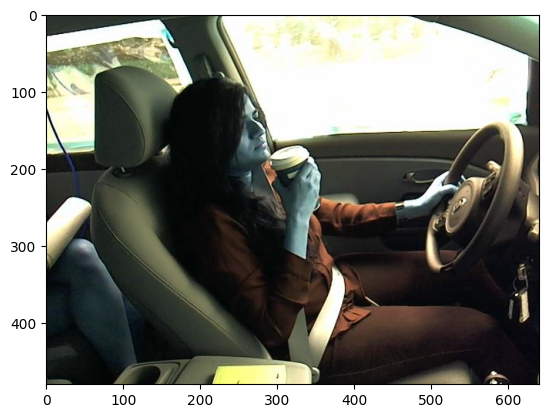

In [89]:
# Drinking
img = cv2.imread("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c6/img_100396.jpg")
img.shape
plt.imshow(img)

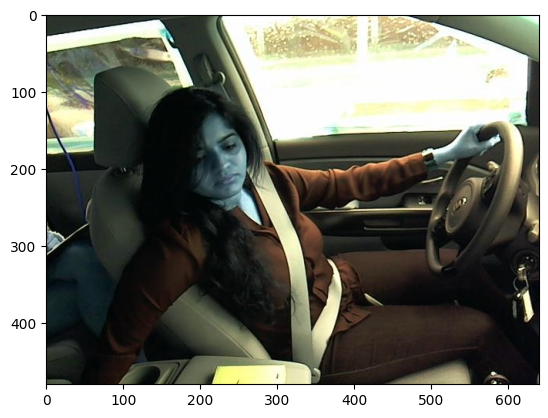

In [90]:
# Reaching behind
img = cv2.imread("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c7/img_100421.jpg")
img.shape
plt.imshow(img)

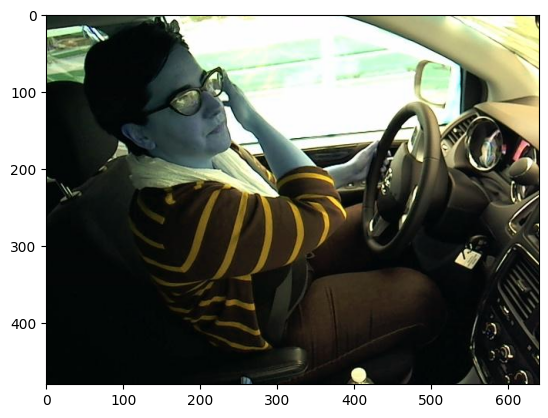

In [91]:
# Hair and makeup
img = cv2.imread("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c8/img_100715.jpg")
img.shape
plt.imshow(img)

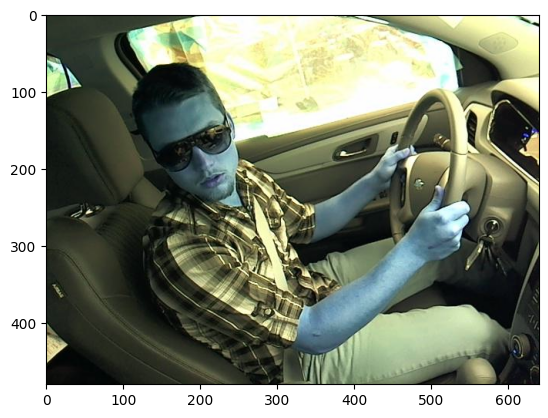

In [92]:
# Talking to passenger
img = cv2.imread("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c9/img_100912.jpg")
img.shape
plt.imshow(img)

In [93]:
print(os.listdir(trainPath))

['c5', 'c7', 'c8', 'c2', 'c6', 'c4', 'c3', 'c1', 'c9', 'c0']


# Loading the Images

In [94]:
labelToIndex = {
    "c0" : 0,    # Safe Driving
    "c1" : 1,    # Texting - Right
    "c2" : 2,    # Talking on the phone - Right
    "c3" : 3,    # Texting - Left
    "c4" : 4,    # Talking on the phone - Left
    "c5" : 5,    # Operating the radio
    "c6" : 6,    # Drinking
    "c7" : 7,    # Reaching behind
    "c8" : 8,    # Hair and makeup
    "c9" : 9     # Talking to passenger
}

In [95]:
def loadImages(path):
    x = []
    y = []
    for label in tqdm(os.listdir(trainPath)):
        path = os.path.join(trainPath, label)
        for img in os.listdir(path):
            image = cv2.imread(os.path.join(path, img))
            resized_image = cv2.resize(image, (80, 80))
            resized_image = resized_image / 255
            x.append(resized_image)
            y.append(labelToIndex[label])
    
    return x, y

In [96]:
x, y = loadImages(trainPath)

100%|██████████| 10/10 [00:57<00:00,  5.70s/it]


One Hot Encoding

In [ ]:
7 -> [0,0,0,0,0,0,0,0 1,0,0]

In [97]:
le = LabelEncoder()
y = le.fit_transform(y)
# print(y)
y = tf.keras.utils.to_categorical(y)

# Preparing the images for model training

In [98]:
 x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [99]:
len(x_train), len(y_train), len(x_test), len(y_test)

(16818, 16818, 5606, 5606)

In [100]:
x_train = np.array(x_train).reshape(-1, 80, 80, 3)
x_test = np.array(x_test).reshape(-1, 80, 80, 3)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [101]:
print(np.array(x_train).shape)
print(np.array(y_train).shape)

(16818, 80, 80, 3)
(16818, 10)


# Models

In [102]:
checkpoint = ModelCheckpoint('model1.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

### 1. Custom CNN Model

In [103]:
model1 = Sequential()

## CNN 1
model1.add(Conv2D(32,(3,3),activation='relu',input_shape=(80, 80, 3)))
model1.add(BatchNormalization())
model1.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model1.add(BatchNormalization(axis = 3))
model1.add(MaxPool2D(pool_size=(2,2),padding='same'))
model1.add(Dropout(0.3))

## CNN 2
model1.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model1.add(BatchNormalization())
model1.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model1.add(BatchNormalization(axis = 3))
model1.add(MaxPool2D(pool_size=(2,2),padding='same'))
model1.add(Dropout(0.3))

## CNN 3
model1.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model1.add(BatchNormalization())
model1.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model1.add(BatchNormalization(axis = 3))
model1.add(MaxPool2D(pool_size=(2,2),padding='same'))
model1.add(Dropout(0.5))

## Output
model1.add(Flatten())
model1.add(Dense(512,activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))
model1.add(Dense(128,activation='relu'))
model1.add(Dropout(0.25))
model1.add(Dense(10,activation='softmax'))

model1.compile(loss = CategoricalCrossentropy(), metrics = ['categorical_accuracy'], optimizer = Adam(0.0003))
history1 = model1.fit(x_train, y_train, epochs = 20, batch_size = 32, validation_data = (x_test, y_test), callbacks=[checkpoint, early_stopping])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
  5/526 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - categorical_accuracy: 0.0838 - loss: 3.4547 

W0000 00:00:1720933198.409738     313 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.3335 - loss: 2.1573

W0000 00:00:1720933219.068593     316 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720933221.008441     315 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 1.53274, saving model to model1.keras


W0000 00:00:1720933222.455266     314 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


526/526 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - categorical_accuracy: 0.3338 - loss: 2.1561 - val_categorical_accuracy: 0.4581 - val_loss: 1.5327
Epoch 2/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.7780 - loss: 0.6678
Epoch 2: val_loss improved from 1.53274 to 0.16439, saving model to model1.keras
526/526 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - categorical_accuracy: 0.7780 - loss: 0.6676 - val_categorical_accuracy: 0.9549 - val_loss: 0.1644
Epoch 3/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.8958 - loss: 0.3246
Epoch 3: val_loss improved from 0.16439 to 0.09332, saving model to model1.keras
526/526 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - categorical_accuracy: 0.8959 - loss: 0.3245 - val_categorical_accuracy: 0.9782 - val_loss: 0.0933
Epoch 4/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9297 - loss: 0.2235
Epoch 4: val_loss improved from 0.09332 to 0.06297, saving model to model1.keras
526/526 ━━━━━━━━━━━━━━━━━━━━ 12

### 2. ResNet50

In [104]:
checkpoint = ModelCheckpoint('model2.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

In [125]:
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(80, 80, 3)))
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)
model2 = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model2.compile(optimizer=Adam(0.0003), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history2 = model2.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
  5/526 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - categorical_accuracy: 0.1488 - loss: 2.3376

W0000 00:00:1720934217.596121     316 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_accuracy: 0.7241 - loss: 0.8558

W0000 00:00:1720934232.582089     314 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720934236.660080     314 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss did not improve from 0.05645
526/526 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - categorical_accuracy: 0.7243 - loss: 0.8551 - val_categorical_accuracy: 0.9329 - val_loss: 0.2338
Epoch 2/20
  7/526 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - categorical_accuracy: 0.9613 - loss: 0.1321

W0000 00:00:1720934241.606165     313 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.9544 - loss: 0.1582
Epoch 2: val_loss did not improve from 0.05645
526/526 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - categorical_accuracy: 0.9544 - loss: 0.1582 - val_categorical_accuracy: 0.9649 - val_loss: 0.1222
Epoch 3/20
525/526 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.9767 - loss: 0.0828
Epoch 3: val_loss did not improve from 0.05645
526/526 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - categorical_accuracy: 0.9767 - loss: 0.0829 - val_categorical_accuracy: 0.9568 - val_loss: 0.1521
Epoch 3: early stopping


### 3. VGG16

In [126]:
checkpoint = ModelCheckpoint('model3.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

In [127]:
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(80, 80, 3)))
x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)
model3 = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
    
model3.compile(optimizer=Adam(0.0003), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history3 = model3.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
  5/526 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - categorical_accuracy: 0.1154 - loss: 2.5643

W0000 00:00:1720934279.287943     314 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_accuracy: 0.7850 - loss: 0.7065

W0000 00:00:1720934292.692678     313 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720934293.943569     316 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.11024, saving model to model3.keras


W0000 00:00:1720934298.490943     313 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


526/526 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - categorical_accuracy: 0.7853 - loss: 0.7058 - val_categorical_accuracy: 0.9693 - val_loss: 0.1102
Epoch 2/20
524/526 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.9875 - loss: 0.0530
Epoch 2: val_loss improved from 0.11024 to 0.07565, saving model to model3.keras
526/526 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - categorical_accuracy: 0.9875 - loss: 0.0530 - val_categorical_accuracy: 0.9786 - val_loss: 0.0757
Epoch 3/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.9957 - loss: 0.0230
Epoch 3: val_loss improved from 0.07565 to 0.05942, saving model to model3.keras
526/526 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - categorical_accuracy: 0.9957 - loss: 0.0230 - val_categorical_accuracy: 0.9820 - val_loss: 0.0594
Epoch 4/20
525/526 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.9979 - loss: 0.0136
Epoch 4: val_loss improved from 0.05942 to 0.05305, saving model to model3.keras
526/526 ━━━━━━━━━━━━━━━━━━━━ 17

# Model Statistics

In [128]:
res1 = model1.evaluate(x_test, y_test)
res2 = model2.evaluate(x_test, y_test)
res3 = model3.evaluate(x_test, y_test)

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - categorical_accuracy: 0.9885 - loss: 0.0428
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - categorical_accuracy: 0.9563 - loss: 0.1476
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - categorical_accuracy: 0.9814 - loss: 0.0725


In [129]:
print(res1)
print(res2)
print(res3)

[0.051581624895334244, 0.9848376512527466]
[0.15212160348892212, 0.9568319916725159]
[0.084968701004982, 0.9791294932365417]


In [130]:
# model1.save("CustomCNNDistraction.h5")
# model2.save("ResNet50Distraction.h5")
# model3.save("VGG16Distraction.h5")

In [131]:
# Driver Distraction (Validation Accuracy, Validation Loss)
# 1. Custom CNN -> 99.7%, 0.0119
# 2. ResNet50 -> 97.14%, 0.1350
# 3. VGG16 -> 98.56%, 0.0945

In [132]:
y_pred = model3.predict(x_test)

  8/176 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step  

W0000 00:00:1720934412.441201     316 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step


W0000 00:00:1720934416.972927     315 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# Confusion Matrix for VGG16 model

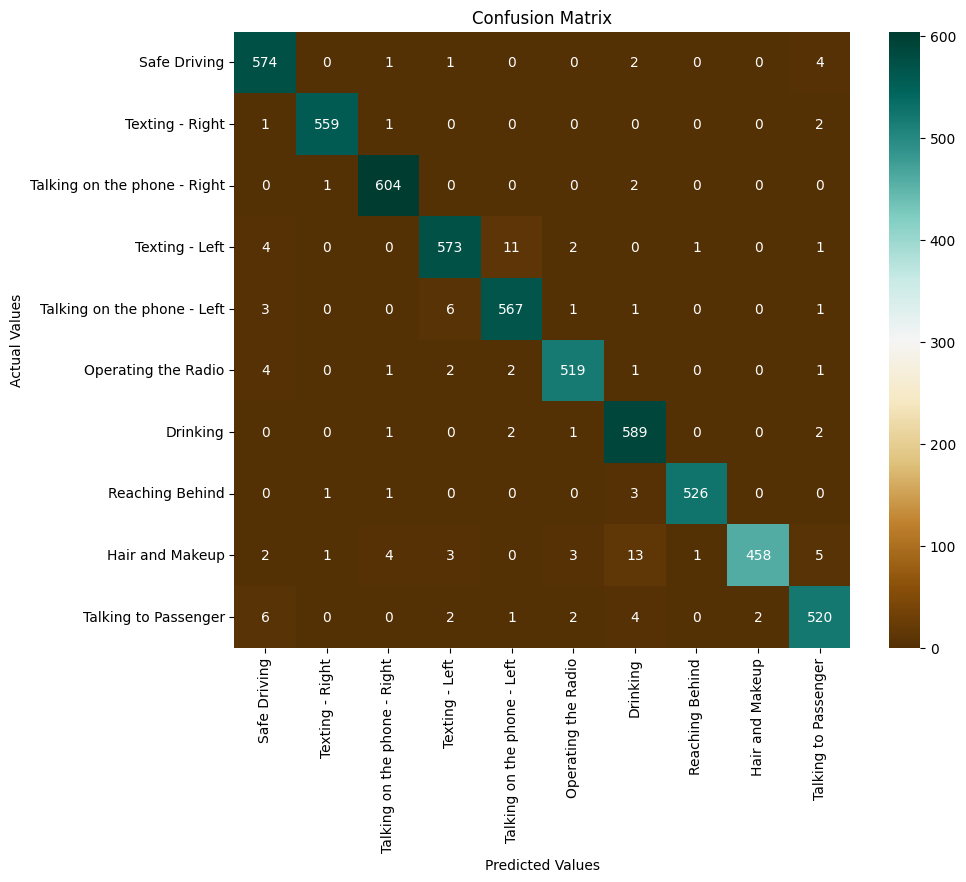

In [133]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_pred and y_test are logits, convert them to class indices
y1 = np.argmax(y_pred, axis=1)
y2 = np.argmax(y_test, axis=1)

# Compute the confusion matrix
mat = confusion_matrix(y2, y1)

# Create the heatmap
plt.figure(figsize=(10, 8))
axes = sns.heatmap(mat, square=True, annot=True, fmt='d',
                   cbar=True, cmap=plt.cm.BrBG)

# Define class labels
class_labels = ["Safe Driving", "Texting - Right", "Talking on the phone - Right", "Texting - Left", "Talking on the phone - Left", "Operating the Radio", "Drinking", "Reaching Behind", "Hair and Makeup", "Talking to Passenger"]

# Set axis labels
axes.set_xlabel('Predicted Values')
axes.set_ylabel('Actual Values')

# Set tick marks and labels
tick_marks = np.arange(len(class_labels)) + 0.5
axes.set_xticks(tick_marks)
axes.set_xticklabels(class_labels, rotation=90)

axes.set_yticks(tick_marks)
axes.set_yticklabels(class_labels, rotation=0)

# Set the title
axes.set_title('Confusion Matrix')

# Show the plot
plt.show()


In [134]:
print(history3.history)

{'categorical_accuracy': [0.9055178761482239, 0.9880484938621521, 0.9950647950172424, 0.9976810812950134, 0.9940540194511414, 0.9916161298751831, 0.9905458688735962], 'loss': [0.33320608735084534, 0.050255052745342255, 0.02342023327946663, 0.014094755053520203, 0.022489435970783234, 0.028511235490441322, 0.031211301684379578], 'val_categorical_accuracy': [0.9693185687065125, 0.9785943627357483, 0.9819836020469666, 0.9860863089561462, 0.98251873254776, 0.9755619168281555, 0.9791294932365417], 'val_loss': [0.11023768037557602, 0.07565007358789444, 0.05942411720752716, 0.05304520204663277, 0.06112547218799591, 0.09068460017442703, 0.084968701004982]}


# Loss and Accuracy for Custom CNN model

Custom CNN Model


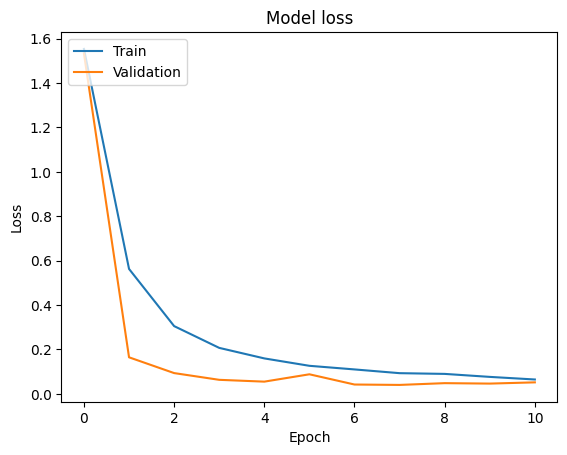

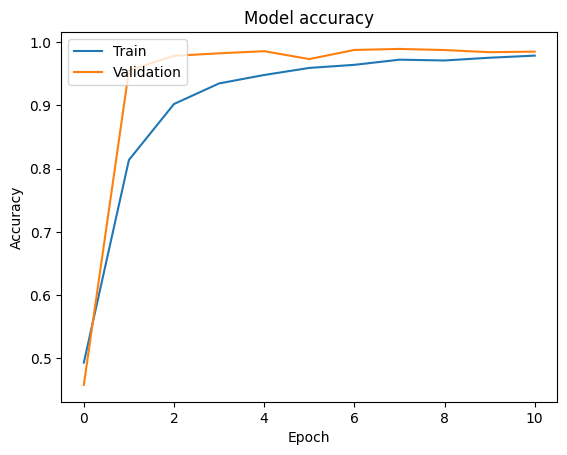

In [135]:
import matplotlib.pyplot as plt
print("Custom CNN Model")
# Plot training & validation loss values
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history1.history['categorical_accuracy'])
plt.plot(history1.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Loss and Accuracy for ResNet50 model

ResNet50 Model


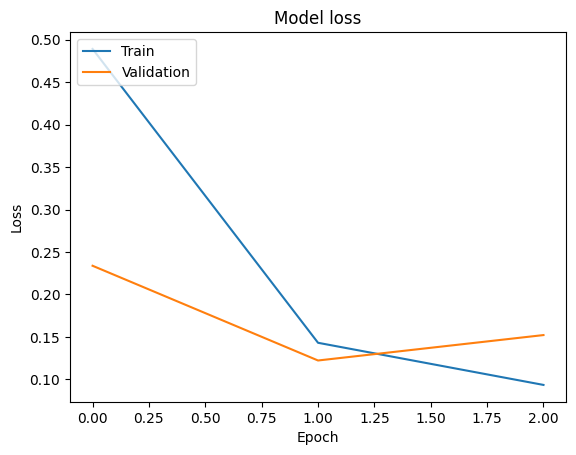

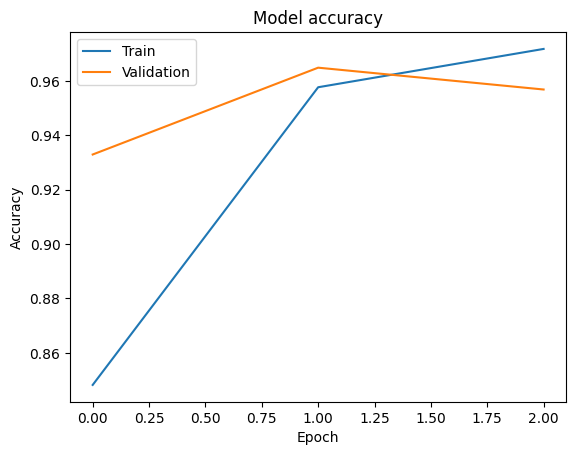

In [136]:
import matplotlib.pyplot as plt
print("ResNet50 Model")

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Loss and Accuracy for VGG16 model

VGG16 Model


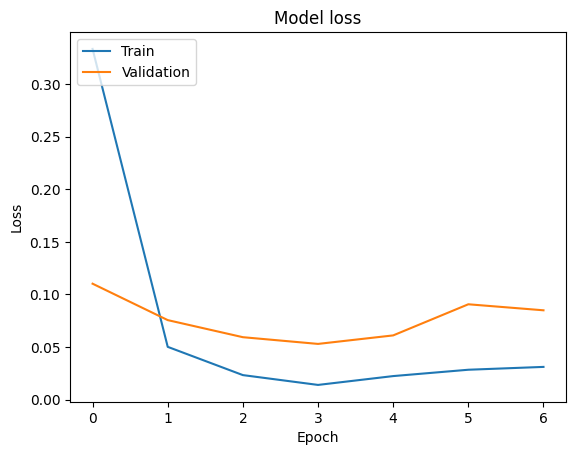

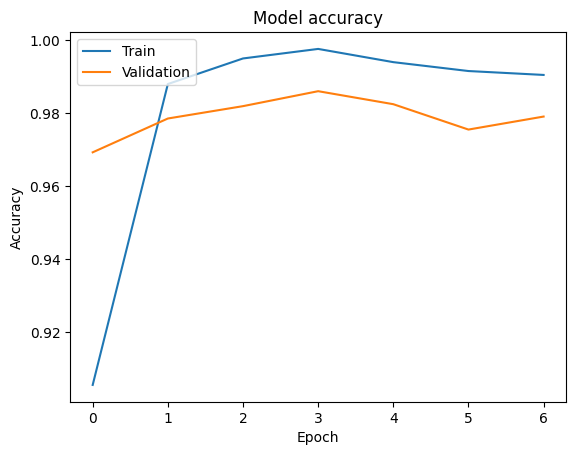

In [137]:
import matplotlib.pyplot as plt
print("VGG16 Model")
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history3.history['categorical_accuracy'])
plt.plot(history3.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Applying model predictions on test images

In [138]:
testPath = "/kaggle/input/state-farm-distracted-driver-detection/imgs/test"

In [139]:
categories = ["Safe Driving", "Texting - Right", "Talking on the phone - Right", "Texting - Left", "Talking on the phone - Left", "Operating the Radio", "Drinking", "Reaching Behind", "Hair and Makeup", "Talking to Passenger"]

In [140]:
def preprocess_image(image):
    if image is None:
        return None
    image = cv2.resize(image, (80, 80))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image

In [141]:
def classify_image(image):
    image = preprocess_image(image) # type: ignore
    if image is None:
        return None
    
    prediction1 = model1.predict(image)
    prediction2 = model2.predict(image)
    prediction3 = model3.predict(image)
    
    class_idx1 = np.argmax(prediction1)
    class_idx2 = np.argmax(prediction2)
    class_idx3 = np.argmax(prediction3)
    
    array = [class_idx1, class_idx2, class_idx3]
    most_freq = max(set(array), key=array.count)
    
    return categories[most_freq]

In [142]:
ans = {}
for image in tqdm(os.listdir(path=testPath)[:10]):
#     print(image)
    img = cv2.imread(os.path.join(testPath, image))
#     plt.imshow(img)
    try:
        ans[image] = [img, classify_image(img)]
#         plt.imshow(img)
#         print(ans[image])
    except:
        print(f"Error processing {image}")
        continue

  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 10%|█         | 1/10 [00:04<00:44,  4.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 20%|██        | 2/10 [00:05<00:17,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 30%|███       | 3/10 [00:05<00:08,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 40%|████      | 4/10 [00:05<00:05,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 50%|█████     | 5/10 [00:05<00:02,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 60%|██████    | 6/10 [00:05<00:01,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 70%|███████   | 7/10 [00:06<00:01,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 80%|████████  | 8/10 [00:06<00:00,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


 90%|█████████ | 9/10 [00:06<00:00,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


In [143]:
def printImage(img, label):
    plt.imshow(img)
    plt.title(label)
    return

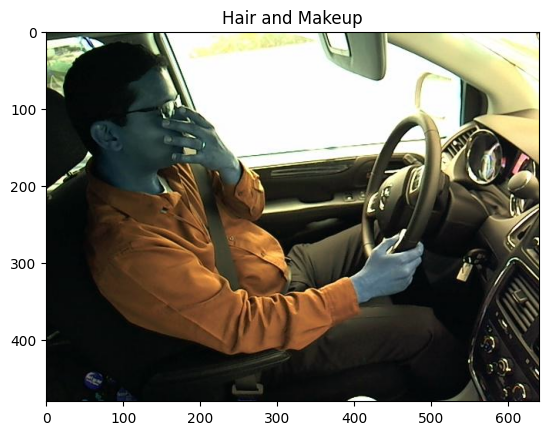

In [144]:
for img_data in ans:
#     printImage(ans[img_data][0], ans[img_data][1])
    plt.title(ans[img_data][1])
    plt.imshow(ans[img_data][0])